In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pgram import pgram

I grabbed some HIRES spectrograph radial velocity data I had lying around from [this dataset](https://ebps.carnegiescience.edu/data/).

In [3]:
data = loadtxt("HD134987_KECK.vels")

Here's the raw data:

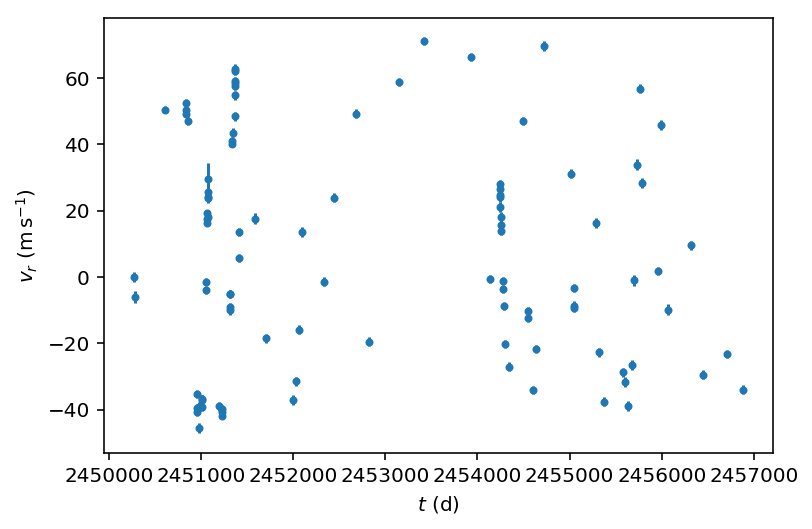

In [4]:
errorbar(data[:,0], data[:,1], data[:,2], fmt='.')
xlabel(r'$t$ ($\mathrm{d}$)')
ylabel(r'$v_r$ ($\mathrm{m} \, \mathrm{s}^{-1}$)')

Now we search over periods, from a small value up to the total length of the data set, and plot the amplitude of the sinusoid fitted at each period.

In [5]:
T = np.max(data[:,0]) - np.min(data[:,0])
dt = median(diff(data[:,0]))
Ps = logspace(log10(2*dt), log10(T), 10000)
mus, As, Bs = zip(*[pgram(data[:,0], data[:,1], data[:,2], P)[0] for P in Ps]) # Note component 0; we ignore the rss
mus, As, Bs = array(mus), array(As), array(Bs)

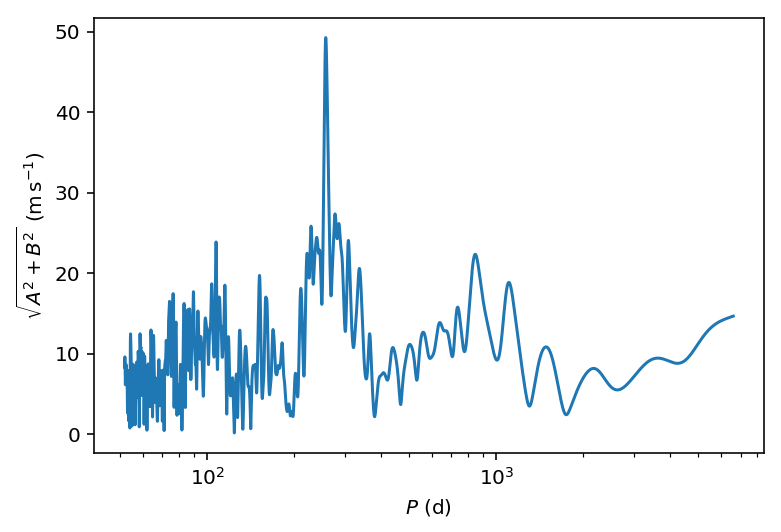

In [6]:
plot(Ps, sqrt(As*As + Bs*Bs))
xscale('log')
xlabel(r'$P$ ($\mathrm{d}$)')
ylabel(r'$\sqrt{A^2 + B^2}$ ($\mathrm{m} \, \mathrm{s}^{-1}$)')

The peak amplitude happes at a particular period; let's plot the model for the data against the data at that period:

<Container object of 3 artists>

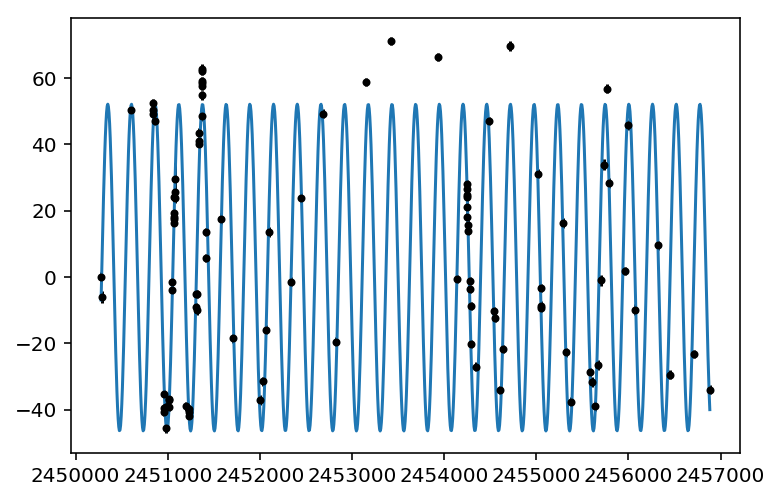

In [7]:
imax = argmax(sqrt(As*As + Bs*Bs))
Pmax = Ps[imax]
mumax = mus[imax]
Amax = As[imax]
Bmax = Bs[imax]

ts = linspace(np.min(data[:,0]), np.max(data[:,0]), 1000)
y_model = mumax + Amax*cos(2*pi*ts/Pmax) + Bmax*sin(2*pi*ts/Pmax)
plot(ts, y_model)
errorbar(data[:,0], data[:,1], data[:,2], fmt='.', color='k')

Now let's try fitting the time series with a second harmonic, too:

In [12]:
params, rsss = zip(*[pgram(data[:,0], data[:,1], data[:,2], P, nharmonics=2) for P in Ps])
mus, A1s, A2s, B1s, B2s = zip(*params)
A1s = array(A1s)
A2s = array(A2s)
B1s = array(B1s)
B2s = array(B2s)
rsss = array(rsss)

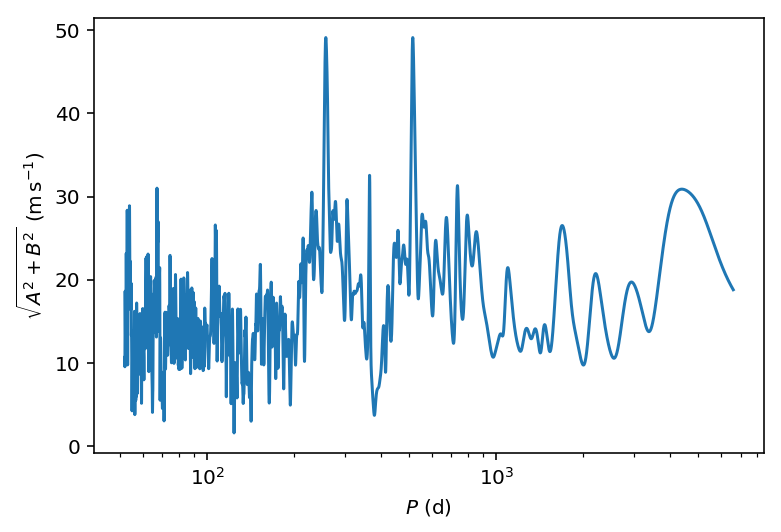

In [13]:
plot(Ps, sqrt(A1s*A1s + A2s*A2s + B1s*B1s + B2s*B2s))
xscale('log')
xlabel(r'$P$ ($\mathrm{d}$)')
ylabel(r'$\sqrt{A^2 + B^2}$ ($\mathrm{m} \, \mathrm{s}^{-1}$)')

The multiple-harmonic version of the periodogram gives *two* peaks, when $P$ is the true period of the system *and* when $P$ is twice the period of the true period; in the former case, the coefficients of the fundamental are large, and in the latter, the coefficients of the first harmonic are large.  Let's look at the residuals.  Remember: the quantity of interest is $\chi^2$ "per degree of freedom," or 
$$
\frac{\chi^2}{N - k} \equiv \sum_{i=1}^{N_\mathrm{obs}} \left(\frac{y_i - F\left( t_i \right)}{\sigma_i}\right),
$$
where $y_i$ is the $i$th measurement, $F(t)$ is the flux model (mean plus two sinusoidal harmonics), and $\sigma_i$ is the uncertainty on the $i$th measurement.  Looking at the plot below, the $\chi^2$ per degree of freedom is not very close to 1, so something about the model is still not very good.  Likely culprits are:

 * Perhaps the observational uncertainties are under-estimated?
 * Perhaps there is an additional source of variability (stellar variability!  stars have all sorts of variability, on all sorts of timescales!) that is present but not folded into the observational uncertainties.
 * If the orbit is fairly eccentric, even two harmonics are not sufficient to properly represent the Fourier series of the orbit, so we may obtain a bad fit.  (Google for "Hansen coefficients" if you want to know more---the H.c. are essentially the Fourier coefficients for the orbit written as functions of the eccentricity.)
 
Nevertheless, we see that the true period provides a smaller summed-squared residual, so is a better model than the false double-period.

(40.605929063594004, 8418.5196988976259, 10, 870.93215899866595)

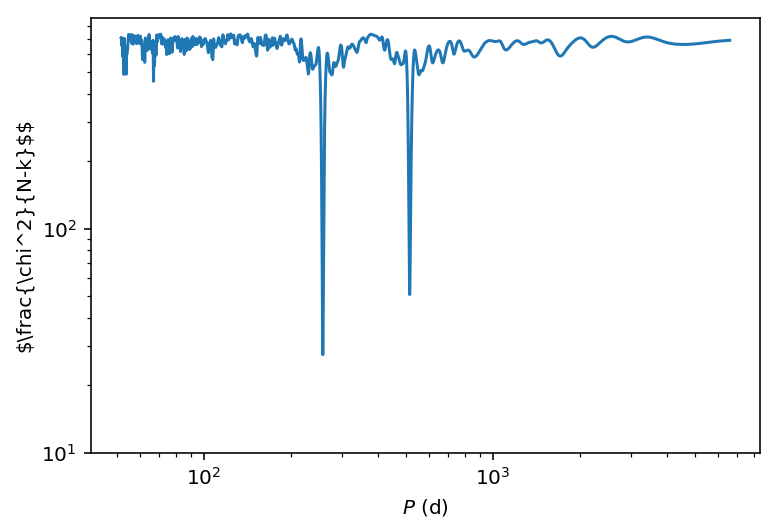

In [17]:
loglog(Ps, rsss/(data.shape[0] - 5))
xlabel(r'$P$ ($\mathrm{d}$)')
ylabel(r'$\frac{\chi^2}{N-k}$$')
axis(ymin=10)